In [1]:
import unittest
import matplotlib
from neuronunit.allenapi.allen_data_driven import opt_setup, opt_setup_two, opt_exec
from neuronunit.allenapi.allen_data_driven import opt_to_model,wrap_setups
from neuronunit.allenapi.utils import dask_map_function

/home/rudolph/anaconda3/lib/python3.8/site-packages/cerberus/validator.py:1607: UserWarning: No validation schema is defined for the arguments of rule 'not_zero_obs_zscore'
  warn(


In [2]:
from neuronunit.optimization.optimization_management import check_bin_vm_soma
from neuronunit.optimization.model_parameters import MODEL_PARAMS, BPO_PARAMS, to_bpo_param
from neuronunit.optimization.optimization_management import dtc_to_rheo,inject_and_plot_model
import numpy as np
from neuronunit.optimization.data_transport_container import DataTC
import efel
from jithub.models import model_classes
import matplotlib.pyplot as plt
import quantities as qt
import os
from sciunit.scores import RelativeDifferenceScore,ZScore

In [3]:


class testOptimization(unittest.TestCase):
    def setUp(self):
        self = self
        self.ids = [ 324257146,
                325479788,
                476053392,
                623893177,
                623960880,
                482493761,
                471819401
               ]
        self.specimen_id = self.ids[1]
    def optimize_job(self,model_type,score_type=ZScore):

        target_num_spikes = 8
        dtc = DataTC()
        dtc.backend = model_type
        dtc.attrs = {k:np.mean(v) for k,v in MODEL_PARAMS[model_type].items()}
        model = dtc.dtc_to_model()
        model.params = BPO_PARAMS[model_type]
        fixed_current = 122 *qt.pA
        if model_type is "ADEXP":
            NGEN = 55
            MU = 15
        else:
            NGEN = 55
            MU = 100
            
        mapping_funct = dask_map_function
        cell_evaluator,simple_cell,suite,target_current,spk_count = wrap_setups(
                  self.specimen_id,
                  model_type,
                  target_num_spikes,
                  template_model=model,
                  fixed_current=False,
                  cached=True,
                  score_type=score_type
        )
        # print(cell_evaluator.cell_model,model_type,cell_evaluator.cell_model.params)
        ##
        #cell_evaluator.cell_model.params = BPO_PARAMS[model_type]
        ###
        final_pop, hall_of_fame, logs, hist = opt_exec(MU,NGEN,mapping_funct,cell_evaluator)
        opt,target = opt_to_model(hall_of_fame,cell_evaluator,suite, target_current, spk_count)
        best_ind = hall_of_fame[0]
        fitnesses = cell_evaluator.evaluate_with_lists(best_ind)
        target.vm_soma = suite.traces['vm15']
        check_bin_vm_soma(target,opt)
        
        #print(0.7>np.sum(fitnesses))
        return np.sum(fitnesses)
    def test_opt_relative_diff(self):
        model_type = "ADEXP"
        sum_fit = self.optimize_job(model_type,score_type=RelativeDifferenceScore)
        print('met fitness goals')
        assert sum_fit<9.0
    def test_opt_ZScore(self):
        model_type = "ADEXP"
        sum_fit = self.optimize_job(model_type,score_type=ZScore)
        print('met fitness goals')
        assert sum_fit<0.7

    def test_opt_relative_diff_izhi(self):
        model_type = "IZHI"
        self.optimize_job(model_type,score_type=RelativeDifferenceScore)

    def test_opt_ZScore_izhi(self):
        model_type = "IZHI"
        self.optimize_job(model_type,score_type=ZScore)


In [4]:
tt = testOptimization()
tt.setUp()

# Z score works

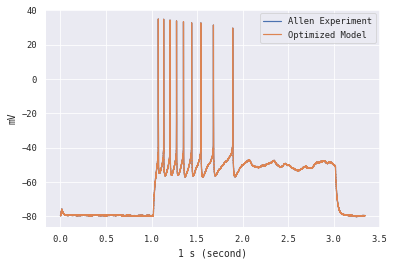

ADEXPModel ADEXP
ADEXPModel ADEXP
ADEXPModel ADEXP {'cm': <bluepyopt.parameters.Parameter object at 0x7f21906975e0>, 'v_spike': <bluepyopt.parameters.Parameter object at 0x7f2190697640>, 'v_reset': <bluepyopt.parameters.Parameter object at 0x7f21906976a0>, 'v_rest': <bluepyopt.parameters.Parameter object at 0x7f2190697700>, 'tau_m': <bluepyopt.parameters.Parameter object at 0x7f2190697760>, 'a': <bluepyopt.parameters.Parameter object at 0x7f21906977c0>, 'b': <bluepyopt.parameters.Parameter object at 0x7f2190697820>, 'delta_T': <bluepyopt.parameters.Parameter object at 0x7f2190697880>, 'tau_w': <bluepyopt.parameters.Parameter object at 0x7f21906978e0>, 'v_thresh': <bluepyopt.parameters.Parameter object at 0x7f2190697940>, 'spike_delta': <bluepyopt.parameters.Parameter object at 0x7f21906979a0>}


2021-01-17 13:51:26.575 INFO    __main__: gen	nevals	avg    	std    	min    	max  
1  	15    	7054.84	8712.31	4.39519	22000


2021-01-17 13:51:34.755 INFO    __main__: 2  	9     	8343.38	8747.23	4.39519	22000
2021-01-17 13:51:40.254 INFO    __main__: 3  	13    	440.552	1792.99	1.45763	8047.46
2021-01-17 13:51:43.986 INFO    __main__: 4  	11    	19.867 	14.2335	1.45763	59.6783
2021-01-17 13:51:46.781 INFO    __main__: 5  	9     	1.45763	2.22045e-16	1.45763	1.45763
2021-01-17 13:51:50.622 INFO    __main__: 6  	11    	1.57369	0.492362   	1.45763	3.6626 
2021-01-17 13:51:55.570 INFO    __main__: 7  	13    	2.29897	1.036      	1.45763	4.1493 
2021-01-17 13:51:59.835 INFO    __main__: 8  	11    	3.17002	1.20805    	1.45763	4.55078
2021-01-17 13:52:03.161 INFO    __main__: 9  	10    	3.12799	1.05344    	1.45763	4.72962
2021-01-17 13:52:06.468 INFO    __main__: 10 	10    	3.59565	1.17797    	1.26449	5.38861
2021-01-17 13:52:09.713 INFO    __main__: 11 	9     	3.14864	0.952028   	1.26449	4.84891
2021-01-17 13:52:13.247 INFO    __main__: 12 	10    	3.30516	1.2345     	1.26449	4.84891
2021-01-17 13:52:15.964 INFO    __m

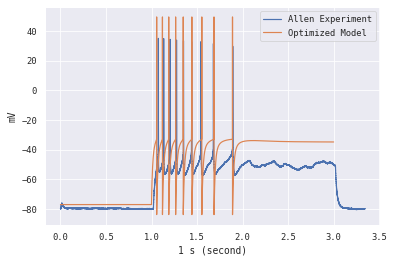

met fitness goals
True


In [5]:

tt.test_opt_ZScore()


# Relative DIfference Also Works Now

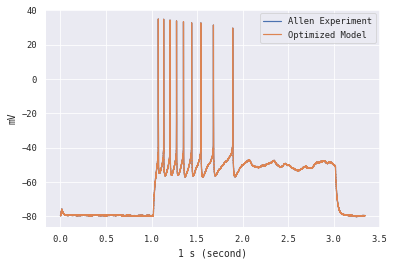

ADEXPModel ADEXP
ADEXPModel ADEXP
ADEXPModel ADEXP {'cm': <bluepyopt.parameters.Parameter object at 0x7f21906975e0>, 'v_spike': <bluepyopt.parameters.Parameter object at 0x7f2190697640>, 'v_reset': <bluepyopt.parameters.Parameter object at 0x7f21906976a0>, 'v_rest': <bluepyopt.parameters.Parameter object at 0x7f2190697700>, 'tau_m': <bluepyopt.parameters.Parameter object at 0x7f2190697760>, 'a': <bluepyopt.parameters.Parameter object at 0x7f21906977c0>, 'b': <bluepyopt.parameters.Parameter object at 0x7f2190697820>, 'delta_T': <bluepyopt.parameters.Parameter object at 0x7f2190697880>, 'tau_w': <bluepyopt.parameters.Parameter object at 0x7f21906978e0>, 'v_thresh': <bluepyopt.parameters.Parameter object at 0x7f2190697940>, 'spike_delta': <bluepyopt.parameters.Parameter object at 0x7f21906979a0>}


2021-01-17 13:55:03.684 INFO    __main__: gen	nevals	avg    	std    	min  	max  
1  	15    	6978.34	8747.24	26.59	22000


2021-01-17 13:55:10.632 INFO    __main__: 2  	9     	8301.44	8757.82	26.59	22000
2021-01-17 13:55:14.709 INFO    __main__: 3  	13    	32.7868	2.50888	26.59	35.6015
2021-01-17 13:55:18.143 INFO    __main__: 4  	11    	28.3121	2.66096	21.727	31.6544
2021-01-17 13:55:20.652 INFO    __main__: 5  	8     	30.6118	2.17852	21.727	31.5326
2021-01-17 13:55:23.155 INFO    __main__: 6  	8     	28.7605	3.28047	21.727	30.9996
2021-01-17 13:55:25.774 INFO    __main__: 7  	8     	29.4195	1.90394	21.727	31.0149
2021-01-17 13:55:29.209 INFO    __main__: 8  	11    	24.6928	3.86482	21.727	31.6245
2021-01-17 13:55:32.643 INFO    __main__: 9  	11    	26.2896	3.75891	21.727	32.5413
2021-01-17 13:55:35.775 INFO    __main__: 10 	10    	25.0656	1.67458	21.727	26.7604
2021-01-17 13:55:37.769 INFO    __main__: 11 	6     	24.3339	1.31186	21.2333	25.6867
2021-01-17 13:55:39.641 INFO    __main__: 12 	6     	22.258 	0.841707	21.2333	23.5637
2021-01-17 13:55:42.456 INFO    __main__: 13 	9     	23.533 	1.11853 	21.2333

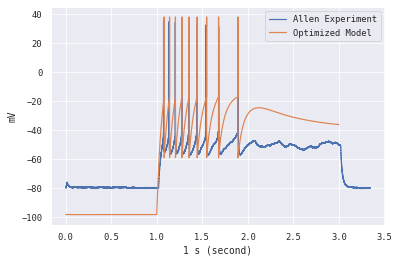

met fitness goals
False


In [6]:

tt.test_opt_relative_diff()

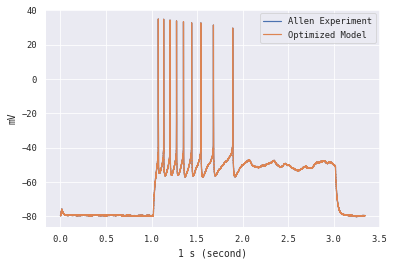

IzhiModel IZHI
IzhiModel IZHI
IzhiModel IZHI {'C': <bluepyopt.parameters.Parameter object at 0x7f2190697220>, 'k': <bluepyopt.parameters.Parameter object at 0x7f2190697280>, 'vr': <bluepyopt.parameters.Parameter object at 0x7f21906972e0>, 'vt': <bluepyopt.parameters.Parameter object at 0x7f2190697340>, 'vPeak': <bluepyopt.parameters.Parameter object at 0x7f21906973a0>, 'a': <bluepyopt.parameters.Parameter object at 0x7f2190697400>, 'b': <bluepyopt.parameters.Parameter object at 0x7f2190697460>, 'c': <bluepyopt.parameters.Parameter object at 0x7f21906974c0>, 'd': <bluepyopt.parameters.Parameter object at 0x7f2190697520>, 'celltype': <bluepyopt.parameters.Parameter object at 0x7f2190697580>}


2021-01-17 13:59:13.774 INFO    __main__: gen	nevals	avg    	std    	min    	max  
1  	100   	6011.28	9628.12	31.6277	22000


2021-01-17 14:00:20.856 INFO    __main__: 2  	72    	6338.02	9747.78	31.6277	22000
2021-01-17 14:00:43.488 INFO    __main__: 3  	68    	826.618	3844.25	31.1577	22000
2021-01-17 14:01:13.498 INFO    __main__: 4  	71    	1882.19	5583.68	31.1577	22000
2021-01-17 14:01:34.811 INFO    __main__: 5  	62    	906.262	3956.82	13.2672	22000
2021-01-17 14:01:49.480 INFO    __main__: 6  	52    	464.681	2791.35	13.2672	22000
2021-01-17 14:02:16.940 INFO    __main__: 7  	61    	1461.25	5231.66	13.2672	22000
2021-01-17 14:02:32.403 INFO    __main__: 8  	66    	212.378	1950.2 	13.2672	22000
2021-01-17 14:02:51.940 INFO    __main__: 9  	63    	678.773	3655.59	13.2672	22000
2021-01-17 14:03:06.767 INFO    __main__: 10 	68    	49.336 	141.305	13.2672	1036.06
2021-01-17 14:03:33.427 INFO    __main__: 11 	64    	1261.39	4886.8 	9.69307	22000  
2021-01-17 14:03:49.549 INFO    __main__: 12 	68    	205.71 	1951.64	8.18122	22000  
2021-01-17 14:04:03.577 INFO    __main__: 13 	66    	153.407	1508.5 	7.65869	1701

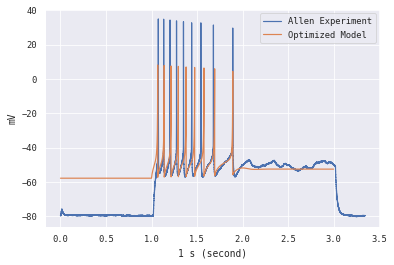

met fitness goals
False


In [7]:
tt.test_opt_relative_diff_izhi()